In [1]:
!pip install librosa
!pip install soundfile
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 22.8 MB/s eta 0:00:0000:01


In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

import logging

from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.inference.TTS import Tacotron2
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

import IPython.display as ipd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torchaudio

from datasets import load_dataset # Expresso dataset
import tqdm.notebook

In [3]:
!git clone https://github.com/cheoljun95/Speech-Articulatory-Coding.git
!cd Speech-Articulatory-Coding && pip install -e .
!mv /kaggle/working/Speech-Articulatory-Coding/* /kaggle/working/ && rm -r /kaggle/working/Speech-Articulatory-Coding

Cloning into 'Speech-Articulatory-Coding'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 81 (delta 34), reused 54 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 3.67 MiB | 10.03 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Obtaining file:///kaggle/working/Speech-Articulatory-Coding
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 24.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.2 MB/s eta 0:00:00
  Running setup.py develop for speech-articulatory-coding


In [4]:
from sparc import load_model
coder = load_model("en", device="cuda:0")

model_english_1500k.yaml:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model_english_1500k.ckpt:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

/kaggle/working/sparc/sparc.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt)


config.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [5]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename='transformer.log', 
                    level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')

assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


# Utils

In [6]:
EPS = 1e-6

def equals(a, b):
    return abs(a - b) < EPS

def dtw(a, b):
    n, m = a.shape[0], b.shape[0]
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(a[i - 1] - b[j - 1])  # Euclidean distance
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j],    # Insertion
                                           dtw_matrix[i, j - 1],    # Deletion
                                           dtw_matrix[i - 1, j - 1]) # Match

    # Backtrack to find the optimal path
    i, j = n, m
    path = []

    while i > 0 or j > 0:
        path.append((i - 1, j - 1))
        if i > 0 and j > 0:
            if equals(dtw_matrix[i, j], dtw_matrix[i - 1, j - 1] + np.linalg.norm(a[i - 1] - b[j - 1])):
                i -= 1
                j -= 1
            elif equals(dtw_matrix[i, j], dtw_matrix[i - 1, j] + np.linalg.norm(a[i - 1] - b[j - 1])):
                i -= 1
            else:
                j -= 1
        elif i > 0:
            i -= 1
        else:
            j -= 1

    path.reverse()
    return dtw_matrix[n, m], path

def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def align(signal_a, signal_b, path):
    aligned_b = np.zeros_like(signal_a)

    for idx_a, idx_b in path:
        aligned_b[idx_a] = signal_b[idx_b]

    return aligned_b

def main(audio_file_1, audio_file_2):
    
    # 0. Load audio files
    audio_a, sr_a = load_audio(audio_file_1)
    audio_b, sr_b = load_audio(audio_file_2)

    # 1. Extract MFCC features
    mfcc_a = librosa.feature.mfcc(y=audio_a, sr=sr_a, n_mfcc=13).T
    mfcc_b = librosa.feature.mfcc(y=audio_b, sr=sr_b, n_mfcc=13).T

    # 2. Normalise MFCC features
    mfcc_a_normalised = (mfcc_a - np.mean(mfcc_a, axis=0))/(np.std(mfcc_a, axis=0))
    mfcc_b_normalised = (mfcc_b - np.mean(mfcc_b, axis=0))/(np.std(mfcc_b, axis=0))

    # 3. Perform DTW
    _, path = dtw(mfcc_a_normalised, mfcc_b_normalised)

    # 4. Align audio_b using DTW path
    mfcc_b_aligned = align_mfcc(mfcc_a_normalised, mfcc_b, path)
    audio_b_aligned = librosa.feature.inverse.mfcc_to_audio(np.einsum("ij->ji", mfcc_b_aligned))

    # 5. Export
    sf.write(f'./{audio_file_2}_aligned.wav', audio_b_aligned, sr_b)
    print(f"Aligned audio saved as '{audio_file_2}_aligned.wav'.")

    return

def naive_cut(audio_file_1, audio_file_2):
    audio_a, _ = load_audio(audio_file_1)
    audio_b, sr_b = load_audio(audio_file_2)
    sf.write('./audio_b_cut.wav', audio_b[:len(audio_a)], sr_b)
    print("Aligned audio saved as 'audio_b_cut.wav'.")

def naive_speed(audio_file_1, audio_file_2):
    audio_a, sr_a = load_audio(audio_file_1)
    audio_b, _ = load_audio(audio_file_2)
    sf.write('./audio_b_speed.wav', audio_b, int(sr_a*len(audio_b)/len(audio_a)))
    print("Aligned audio saved as 'audio_b_speed.wav'.")

In [7]:
# Load a pretrained HIFIGAN Vocoder
tacotron2 = Tacotron2.from_hparams(source="speechbrain/tts-tacotron2-ljspeech", savedir="tmpdir_tts")
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-ljspeech", savedir="tmpdir_vocoder")

def view_spectrogram(spectrogram, title="Mel Spectrogram", n_mels=80):
    if not isinstance(spectrogram, np.ndarray):
        spectrogram = spectrogram.numpy()
    if spectrogram.shape[0] != 80:
        spectrogram = np.einsum("ij->ji", spectrogram)
    assert spectrogram.shape[0] == n_mels, f"spectrogram shape {spectrogram.shape} != ({n_mels}, seq_length)"
    print(spectrogram.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def get_spectrogram(file_name):

    signal, rate = torchaudio.load(file_name)
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    return spectrogram

def get_spectrogram_from_waveform(signal, rate):
    
    if isinstance(signal, np.ndarray):
        signal = torch.tensor(signal, dtype=torch.float32)
    
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    return spectrogram

def spectrogram_to_waveform(spectrogram, save_file_name):
    waveforms = hifi_gan.decode_batch(spectrogram) # spectrogram to waveform
    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def get_reconstructed_sample(file_name, save_file_name):

    signal, rate = torchaudio.load(file_name)
    signal = torchaudio.functional.resample(signal, orig_freq=rate, new_freq=22050)

    spectrogram, _ = mel_spectogram(
        audio=signal.squeeze(),
        sample_rate=22050,
        hop_length=256,
        win_length=None,
        n_mels=80,
        n_fft=1024,
        f_min=0.0,
        f_max=8000.0,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )

    waveforms = hifi_gan.decode_batch(spectrogram) # spectrogram to waveform

    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def transcript_to_audio(sentence, save_file_name):
    
    mel_output, mel_length, alignment = tacotron2.encode_text(sentence)
    # 1. Mel spectrogram with properties in the Tacotron paper (or see get_reconstructed_sample)
    #    Shape = (batch_size, n_mels=80, Mel_length + 1); Mel_length proportional to length of sequence
    # 2. Mel_length = mel_output.shape[2] - 1
    # 3. Alignment
    #    Shape = (batch_size, Mel_length, Token_length) where Token_length is from tacotron2.text_to_seq(txt)

    waveforms = hifi_gan.decode_batch(mel_output) # spectrogram to waveform

    torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)

def transcript_to_mel(sentence):
    mel_output, mel_length, alignment = tacotron2.encode_text(sentence)
    return mel_output.squeeze() # remove the batch dimension

def mel_to_audio(mel_output, save_file_name=None, display=False):
    if isinstance(mel_output, np.ndarray):
        mel_output = torch.tensor(mel_output)
    if mel_output.shape[0] != 80:
        mel_output = torch.einsum("ij->ji", mel_output)
    waveforms = hifi_gan.decode_batch(mel_output) # spectrogram to waveform
    if save_file_name is not None: torchaudio.save(save_file_name, waveforms.squeeze(1), 22050)
    if display: return ipd.Audio(waveforms, rate=22050)
    return waveforms

def sample_audio(dataset, idx:int):
    print(dataset[idx])
    mel_to_audio(torch.einsum("ij->ji", dataset[idx]["data_mel"]), f"sample_{idx}.wav")
    mel_to_audio(torch.einsum("ij->ji", torch.tensor(dataset[idx]["original_data_mel"])), f"sample_{idx}_original.wav")

hyperparams.yaml:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

hyperparams.yaml:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

generator.ckpt:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

In [8]:
dataset = torch.load("/kaggle/input/speaker4-sparc/sparc_speaker4.pth")

/tmp/ipykernel_23/706944666.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("/kaggle/input/speaker4-sparc/sparc_speaker4.pth")


# Visualise

In [9]:
dataset.keys()

dict_keys(['training_data', 'validation_data', 'testing_data'])

In [11]:
len(dataset["training_data"]), len(dataset["validation_data"]), len(dataset["testing_data"])

(2000, 450, 453)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'confused'),
  Text(1, 0, 'whisper'),
  Text(2, 0, 'laughing'),
  Text(3, 0, 'essentials'),
  Text(4, 0, 'enunciated'),
  Text(5, 0, 'singing'),
  Text(6, 0, 'emphasis'),
  Text(7, 0, 'sad'),
  Text(8, 0, 'happy'),
  Text(9, 0, 'default')])

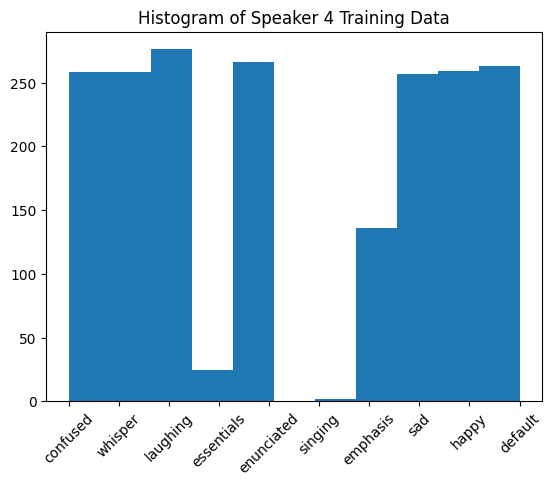

In [24]:
label_decoder = {
    0: 'confused',
    1: 'default',
    2: 'emphasis',
    3: 'enunciated',
    4: 'essentials',
    5: 'happy',
    6: 'laughing',
    7: 'longform',
    8: 'sad',
    9: 'singing',
    10:'whisper'
}
plt.title("Histogram of Speaker 4 Training Data")
plt.hist([label_decoder[x["label"].item()] for x in dataset["training_data"]], bins=11)
plt.xticks(rotation=45)

In [21]:
set([label_decoder[x["label"].item()] for x in dataset["training_data"]])

{'confused',
 'default',
 'emphasis',
 'enunciated',
 'essentials',
 'happy',
 'laughing',
 'sad',
 'singing',
 'whisper'}

In [22]:
counter_c = dict()
for w in [label_decoder[x["label"].item()] for x in dataset["training_data"]]:
    counter_c[w] = counter_c.get(w, 0) + 1

In [23]:
counter_c

{'confused': 258,
 'whisper': 258,
 'laughing': 276,
 'essentials': 25,
 'enunciated': 266,
 'singing': 2,
 'emphasis': 136,
 'sad': 257,
 'happy': 259,
 'default': 263}

In [11]:
dataset["training_data"][0].keys()

dict_keys(['ai_sparc', 'ai_sparc_loudness', 'ai_sparc_pitch', 'ai_sparc_spk_emb', 'data_sparc', 'data_sparc_loudness', 'data_sparc_pitch', 'data_sparc_spk_emb', 'label'])

In [17]:
torch.flatten(dataset["training_data"][0]["ai_sparc_loudness"]).shape

torch.Size([205])

In [32]:
torch.flatten(dataset["training_data"][0]["ai_sparc_pitch"]).shape

torch.Size([205])

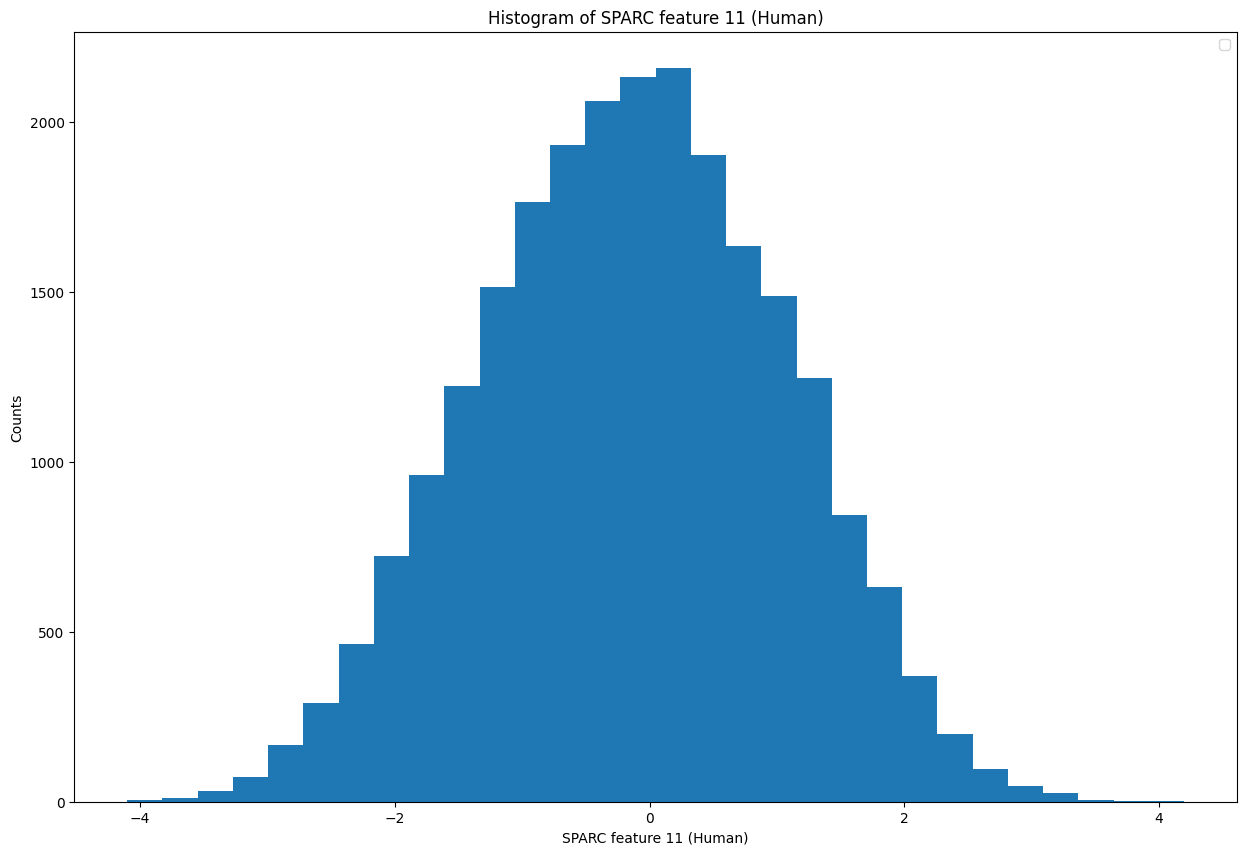

In [24]:
feature_idx = 11
all_feature = []

for x in dataset["training_data"]:
    all_feature = all_feature + torch.flatten(x["data_sparc"][feature_idx]).tolist()

plt.figure(figsize=(15,10))
plt.hist(all_feature, bins=30)
plt.xlabel(f'SPARC feature {feature_idx} (Human)') 
plt.ylabel('Counts')
plt.legend()
plt.title(f'Histogram of SPARC feature {feature_idx} (Human)')
plt.show()

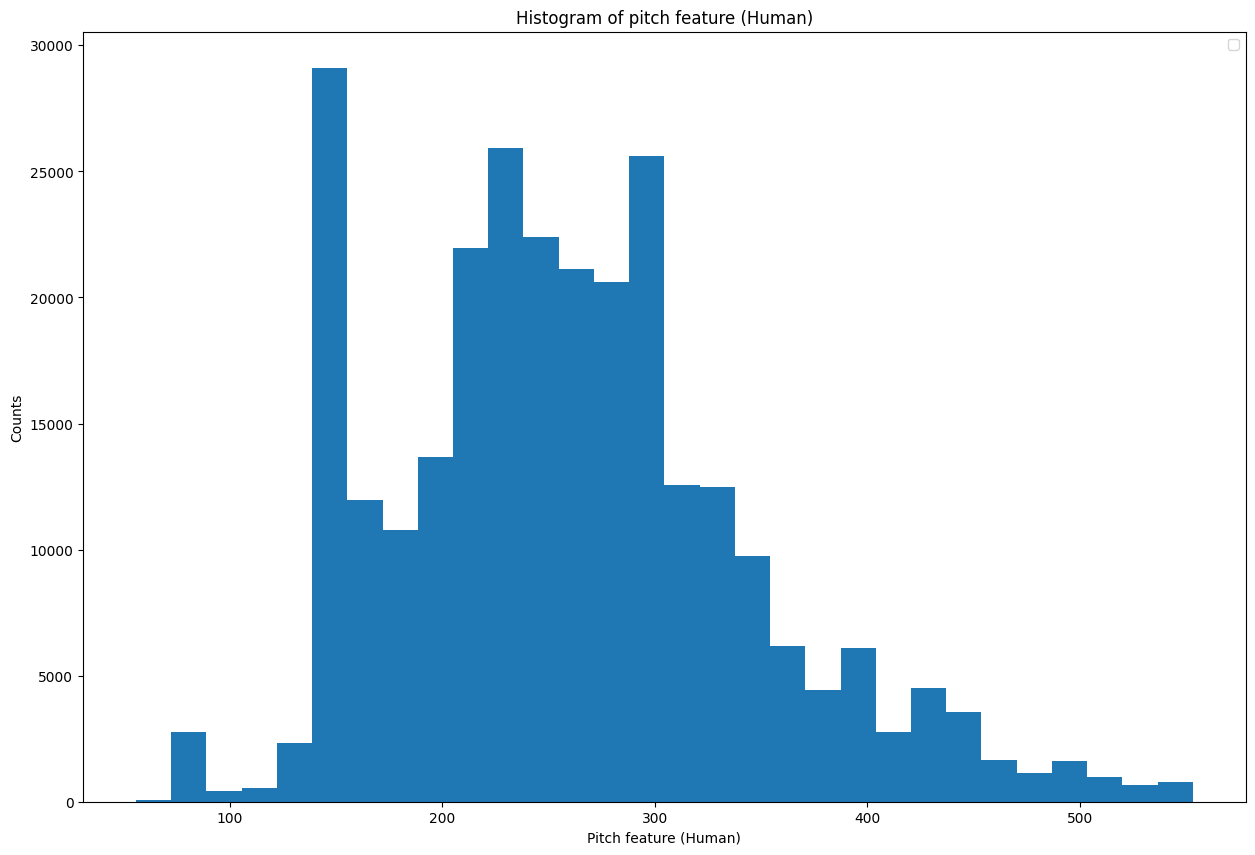

In [51]:
all_pitch = []
for x in dataset["training_data"]:
    all_pitch = all_pitch + torch.flatten(x["data_sparc_pitch"]).tolist()

plt.figure(figsize=(15,10))
plt.hist(all_pitch, bins=30)
plt.xlabel('Pitch feature (Human)') 
plt.ylabel('Counts')
plt.legend()
plt.title('Histogram of pitch feature (Human)')
plt.show()

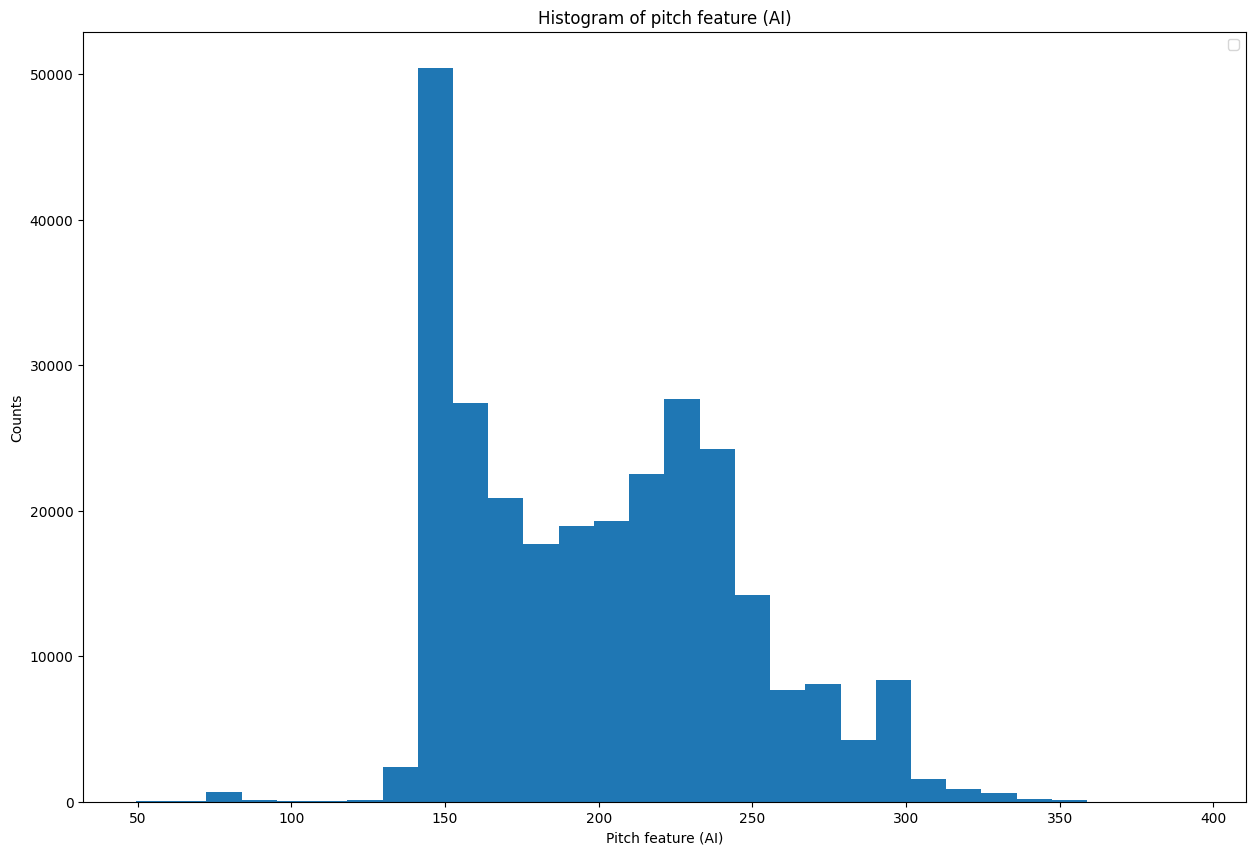

In [52]:
all_pitch = []
for x in dataset["training_data"]:
    all_pitch = all_pitch + torch.flatten(x["ai_sparc_pitch"]).tolist()

plt.figure(figsize=(15,10))
plt.hist(all_pitch, bins=30)
plt.xlabel('Pitch feature (AI)') 
plt.ylabel('Counts')
plt.legend()
plt.title('Histogram of pitch feature (AI)')
plt.show()

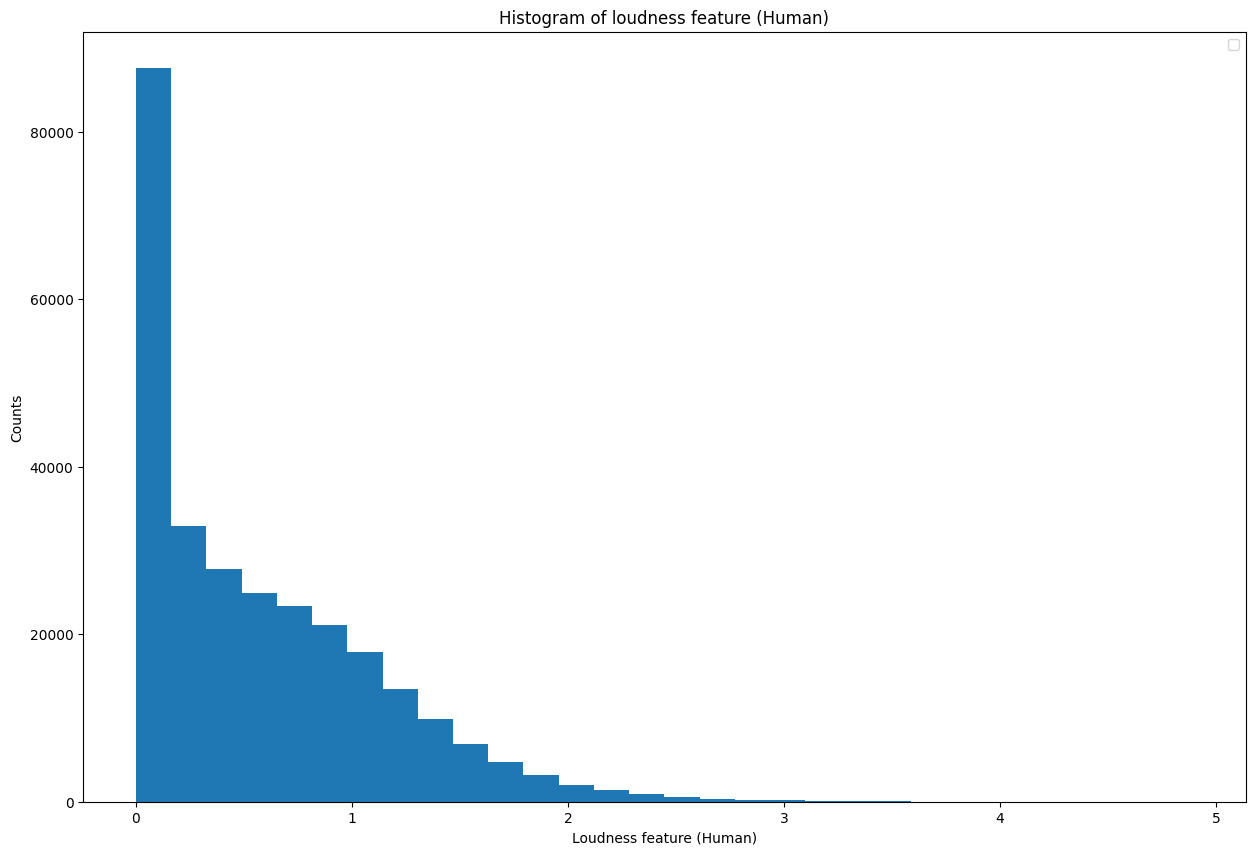

In [47]:
all_loudness = []
for x in dataset["training_data"]:
    all_loudness = all_loudness + torch.flatten(x["data_sparc_loudness"]).tolist()

plt.figure(figsize=(15,10))
plt.hist(all_loudness, bins=30)
plt.xlabel('Loudness feature (Human)') 
plt.ylabel('Counts')
plt.legend()
plt.title('Histogram of loudness feature (Human)')
plt.show()

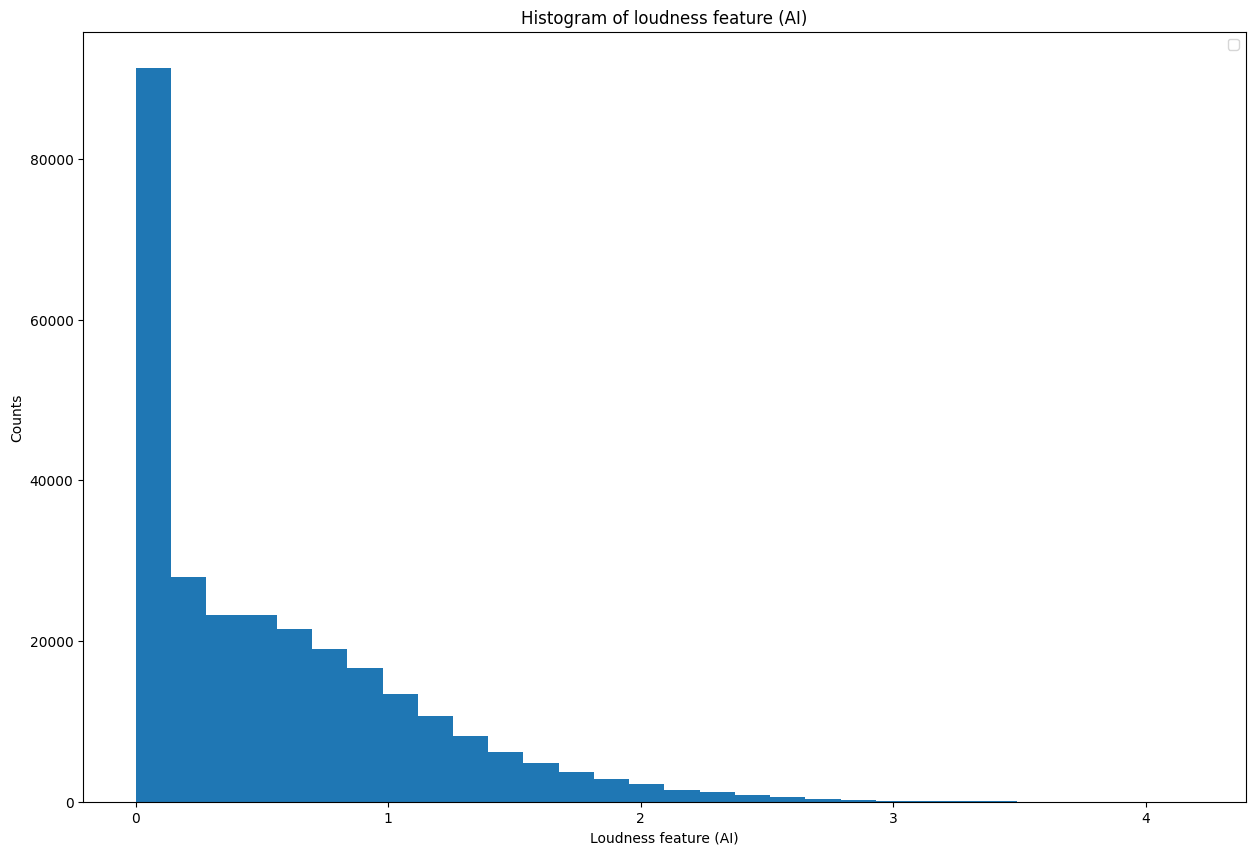

In [46]:
all_loudness = []
for x in dataset["training_data"]:
    all_loudness = all_loudness + torch.flatten(x["ai_sparc_loudness"]).tolist()

plt.figure(figsize=(15,10))
plt.hist(all_loudness, bins=30)
plt.xlabel('Loudness feature (AI)') 
plt.ylabel('Counts')
plt.legend()
plt.title('Histogram of loudness feature (AI)')
plt.show()

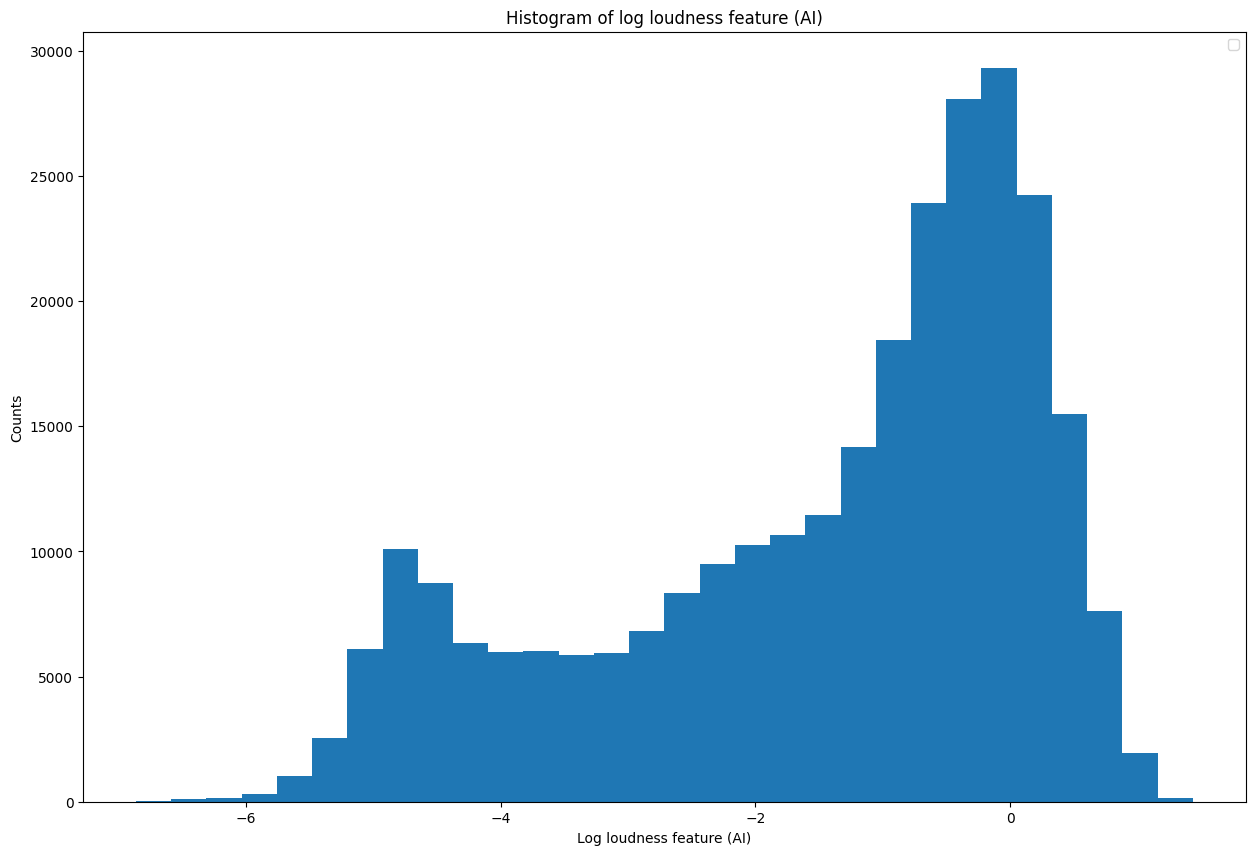

In [50]:
all_loudness = []
for x in dataset["training_data"]:
    all_loudness = all_loudness + torch.flatten(torch.log(x["ai_sparc_loudness"])).tolist()

plt.figure(figsize=(15,10))
plt.hist(all_loudness, bins=30)
plt.xlabel('Log loudness feature (AI)') 
plt.ylabel('Counts')
plt.legend()
plt.title('Histogram of log loudness feature (AI)')
plt.show()

In [38]:
torch.flatten(dataset["training_data"][0]["ai_sparc_pitch"] - 225)

tensor([ 71.9492,  66.1328,  64.5865,  42.8859,  15.5690,  14.8919,  13.7863,
         12.5600,  10.7208,   0.8358,  -1.4303,   5.0966,   5.7637,   6.4337,
          6.1377,   5.7632,   8.7453,   8.5914,   9.2947,   9.2226,   8.6260,
          9.1813,  12.1718,  11.4787,  11.7633,  11.7229,  17.6463,  12.2258,
          5.1889,   0.8906,  -2.8937,  -3.7115,  -6.1148, -13.1472, -18.9699,
         -9.9783,  -6.9564,  -4.2043,  -4.3282,  -4.9938,  -4.4762,  -5.1457,
         -4.6619,  -4.3405, -28.9168, -66.8763, -71.3991, -71.9895, -71.8525,
        -72.2712, -71.9684, -72.3046, -73.3270, -74.3703, -74.8848, -76.0331,
        -76.6457, -76.0533, -76.1326, -76.1096, -76.2328, -77.3195, -77.3261,
        -77.9852, -77.9108, -77.7271, -80.3821, -83.6897])

(array([59., 26.,  7., 12., 17., 38., 10., 15.,  4., 17.]),
 array([-80.39324951, -64.94827271, -49.5032959 , -34.05831909,
        -18.61334229,  -3.16836548,  12.27661133,  27.72158813,
         43.16656494,  58.61154175,  74.05651855]),
 <BarContainer object of 10 artists>)

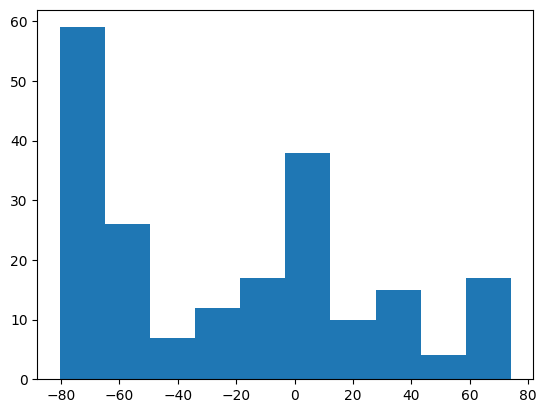

In [20]:
plt.hist(torch.flatten(dataset["training_data"][0]["ai_sparc_pitch"] - 225))

In [13]:
dataset["training_data"][1]["ai_sparc"].shape

torch.Size([48, 12])

In [15]:
dataset["training_data"][1]["ai_sparc_pitch"][1:].shape

torch.Size([48, 1])

In [25]:
torch.cat((
    dataset["training_data"][1]["ai_sparc"], 
    (dataset["training_data"][1]["ai_sparc_pitch"][:-1] - 225)/25, 
    torch.log(dataset["training_data"][1]["ai_sparc_loudness"][:-1]) + 2
), dim=1)

tensor([[-1.4948e-01,  5.4606e-02, -7.3691e-02,  3.4370e-01, -3.3830e-01,
          3.5104e-01, -3.3974e-01,  4.9377e-01, -1.0262e-02,  7.5361e-01,
         -1.6873e-01,  3.8909e-01,  2.1512e+00, -2.5305e+00],
        [-7.6030e-01,  5.8978e-01, -6.2121e-01,  6.6262e-01, -2.2371e-01,
          3.5205e-01, -1.2255e+00,  8.3267e-01, -3.4675e-01,  5.1028e-01,
         -1.1191e+00,  7.2012e-01,  2.1592e+00, -2.0916e+00],
        [-1.3200e+00,  8.9668e-01, -1.0333e+00,  8.7713e-01, -2.5240e-01,
          5.4840e-01, -1.9085e+00,  1.1237e+00, -4.0112e-01,  5.2584e-01,
         -1.6895e+00,  8.0489e-01,  2.0722e+00, -2.0220e+00],
        [-1.7590e+00,  8.7084e-01, -1.2876e+00,  8.9960e-01, -4.9612e-01,
          8.4579e-01, -2.2364e+00,  1.3032e+00, -1.0089e-01,  8.5262e-01,
         -1.7104e+00,  5.5863e-01,  2.1228e+00, -2.1972e+00],
        [-2.0106e+00,  5.8059e-01, -1.4510e+00,  7.0169e-01, -8.9151e-01,
          9.4074e-01, -2.1890e+00,  1.3193e+00,  3.7197e-01,  1.2991e+00,
         -1.

In [ ]:
plt.hist(torch.flatten(dataset["training_data"][1]["ai_sparc_pitch"]))

(array([24., 18.,  5.,  6.,  6.,  5.,  1.,  2.,  8.,  7.]),
 array([-78.24963379, -59.80924988, -41.36886597, -22.92848206,
         -4.48809814,  13.95228577,  32.39266968,  50.83305359,
         69.2734375 ,  87.71382141, 106.15420532]),
 <BarContainer object of 10 artists>)

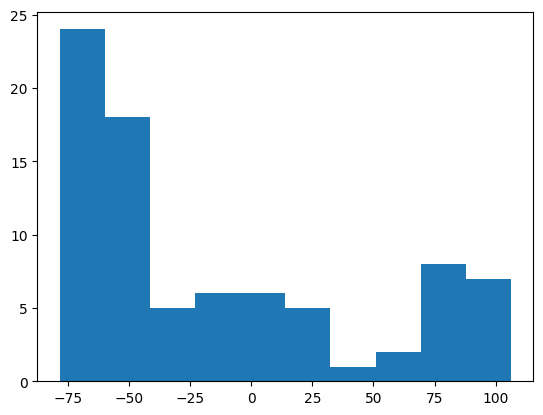

In [11]:
plt.hist(torch.flatten(dataset["training_data"][2]["ai_sparc_pitch"]) - 225)

(array([27.,  7.,  6., 10., 15., 15., 18., 37., 42., 28.]),
 array([-5.04626369, -4.4594593 , -3.87265468, -3.28585005, -2.69904566,
        -2.11224103, -1.52543652, -0.93863201, -0.35182747,  0.23497705,
         0.82178158]),
 <BarContainer object of 10 artists>)

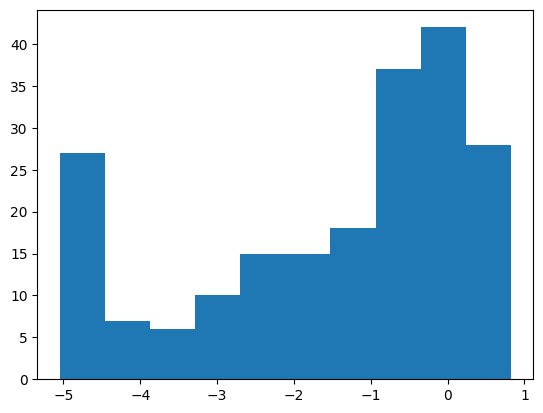

In [24]:
plt.hist(torch.log(torch.flatten(dataset["training_data"][0]["ai_sparc_loudness"])))

(array([ 8.,  4.,  0.,  2.,  4.,  3.,  2.,  6., 12.,  8.]),
 array([-4.81210613, -4.25791645, -3.70372677, -3.14953709, -2.5953474 ,
        -2.04115772, -1.48696792, -0.93277824, -0.37858853,  0.17560117,
         0.72979087]),
 <BarContainer object of 10 artists>)

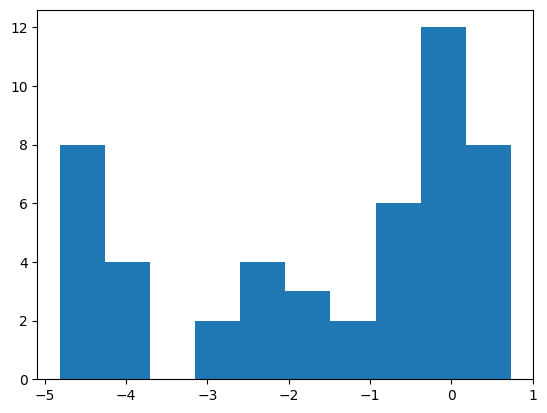

In [25]:
plt.hist(torch.log(torch.flatten(dataset["training_data"][1]["ai_sparc_loudness"])))

(array([ 4.,  5.,  3.,  5.,  8.,  6.,  9., 17., 16., 10.]),
 array([-4.35823965, -3.84175277, -3.32526612, -2.80877924, -2.29229236,
        -1.77580559, -1.25931883, -0.74283195, -0.22634515,  0.29014164,
         0.80662847]),
 <BarContainer object of 10 artists>)

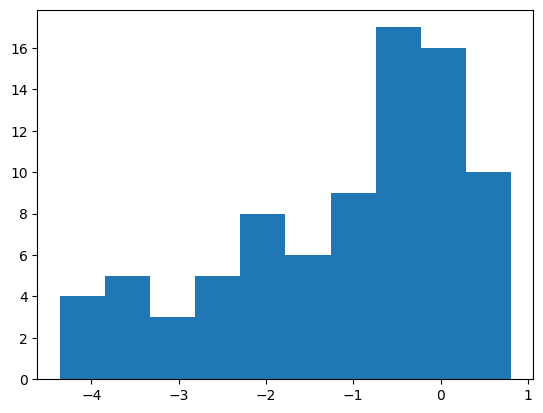

In [26]:
plt.hist(torch.log(torch.flatten(dataset["training_data"][2]["ai_sparc_loudness"])))

(array([ 9., 13., 11., 14., 20., 23., 40., 58., 72., 12.]),
 array([-4.71493864, -4.14879036, -3.58264184, -3.01649356, -2.45034528,
        -1.88419688, -1.3180486 , -0.7519002 , -0.18575187,  0.38039649,
         0.94654483]),
 <BarContainer object of 10 artists>)

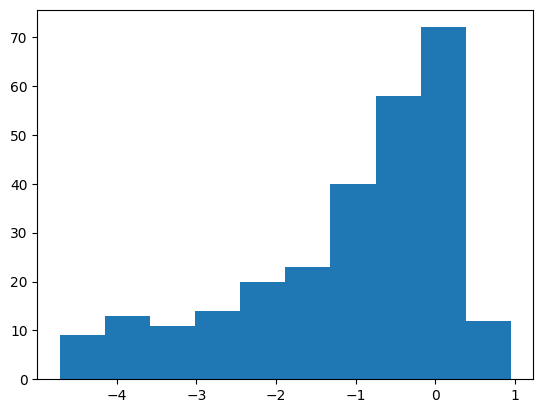

In [27]:
plt.hist(torch.log(torch.flatten(dataset["training_data"][3]["ai_sparc_loudness"])))

In [12]:
dataset["training_data"][0]["ai_sparc"].shape

torch.Size([204, 12])

In [ ]:
wav_ai = coder.decode(
    ema=dataset["training_data"][0]["ai_sparc"].numpy(), 
    pitch=dataset["training_data"][0]["ai_sparc_pitch"].numpy(), 
    loudness=dataset["training_data"][0]["ai_sparc_loudness"].numpy(), 
    spk_emb=dataset["training_data"][0]["ai_sparc_spk_emb"].numpy()
)

In [ ]:
ipd.display(ipd.Audio(wav_ai, rate=coder.sr))

In [ ]:
view_spectrogram(get_spectrogram_from_waveform(wav_ai, coder.sr), title="Mel Spectrogram (AI)")

In [ ]:
wav_human = coder.decode(
    ema=dataset["training_data"][0]["data_sparc"].numpy(), 
    pitch=dataset["training_data"][0]["data_sparc_pitch"].numpy(), 
    loudness=dataset["training_data"][0]["data_sparc_loudness"].numpy(), 
    spk_emb=dataset["training_data"][0]["data_sparc_spk_emb"].numpy()
)

In [ ]:
ipd.display(ipd.Audio(wav_human, rate=coder.sr))

In [ ]:
view_spectrogram(get_spectrogram_from_waveform(wav_human, coder.sr), title="Mel Spectrogram (Actual)")

In [9]:
class ProcessedSparcSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, split, data):
        assert split in ("train", "valid", "test"), "invalid split"
        m = {
            "train": "training_data",
            "valid": "validation_data",
            "test": "testing_data"
        }
        self.data = data
        self.split = m[split]
        
        import random
        random.seed(225) # reproducibility
        random.shuffle(self.data["training_data"])

    def __len__(self):
        return len(self.data[self.split])

    def __getitem__(self, idx:int):
        assert idx >= 0 and idx < len(self), "Index error in ProcessedSparcSpectrogramDataset"
        return self.data[self.split][idx]
    
    @staticmethod
    def collate(batch):
        
        assert torch.cuda.is_available()
        device = torch.device("cuda")
        
        ai_mel = pad_sequence(
            [
                torch.cat((
                    item["ai_sparc"], 
                    (item["ai_sparc_pitch"][:len(item["ai_sparc"])] - 225)/25, 
                    torch.log(item["ai_sparc_loudness"][:len(item["ai_sparc"])]) + 2
                ), dim=1)
                for item in batch],
            batch_first=True, padding_value=np.nan
        )
        data_mel = pad_sequence(
            [
                torch.cat((
                    item["data_sparc"], 
                    (item["data_sparc_pitch"][:len(item["data_sparc"])] - 225)/25, 
                    torch.log(item["data_sparc_loudness"][:len(item["data_sparc"])]) + 2
                ), dim=1)
                for item in batch],
            batch_first=True, padding_value=np.nan
        )
#         duration = pad_sequence(
#             [item["duration"] for item in batch],
#             batch_first=True, padding_value=np.nan
#         )
        labels = torch.cat(tuple([item["label"] for item in batch]))
#         sequence_lengths = torch.cat(tuple([item["sequence_length"] for item in batch]))
        mask = torch.all(torch.where(torch.isnan(ai_mel), torch.full(ai_mel.shape, True), torch.full(ai_mel.shape, False)), 2)
        mask_check = torch.all(torch.where(torch.isnan(data_mel), torch.full(data_mel.shape, True), torch.full(data_mel.shape, False)), 2)
#         mask_double_check = torch.where(torch.isnan(duration), torch.full(duration.shape, True), torch.full(duration.shape, False))
        assert torch.equal(mask, mask_check), "mask is dubious"
#         assert torch.equal(mask, mask_double_check), f"mask is dubious {mask.shape}, {mask_double_check.shape}"
        ai_mel = pad_sequence(
            [
                torch.cat((
                    item["ai_sparc"], 
                    (item["ai_sparc_pitch"][:len(item["ai_sparc"])] - 225)/25, 
                    torch.log(item["ai_sparc_loudness"][:len(item["ai_sparc"])]) + 2
                ), dim=1)
                for item in batch],
            batch_first=True, padding_value=0.0
        )
        data_mel = pad_sequence(
            [
                torch.cat((
                    item["data_sparc"], 
                    (item["data_sparc_pitch"][:len(item["data_sparc"])] - 225)/25, 
                    torch.log(item["data_sparc_loudness"][:len(item["data_sparc"])]) + 2
                ), dim=1)
                for item in batch],
            batch_first=True, padding_value=0.0
        )
#         duration = pad_sequence(
#             [item["duration"] for item in batch],
#             batch_first=True, padding_value=0.0
#         )
        
        batch_size = len(batch)
        _, ai_mel_max_length, _ = ai_mel.shape
        assert ai_mel.shape == (batch_size, ai_mel_max_length, 14) # SPARC has 14 features
        assert data_mel.shape == ai_mel.shape
#         assert duration.shape == ai_mel.shape[:2]
#         assert sequence_lengths.shape == torch.Size([batch_size])
#         assert torch.all(sequence_lengths > 0), "not all sequence lengths are positive"
        assert mask.shape == ai_mel.shape[:2]
        
        return {
            "ai_sparc": ai_mel.to(device),
            "data_sparc": data_mel.to(device), 
            "labels": labels.to(device),
#             "sequence_length": sequence_lengths.to(device),
            "mask": mask.to(device) #,
#             "duration": duration.to(device)
        }

# Model

In [10]:
class EmotionModel(nn.Module):
    def transform(self, batch):
        raise NotImplementedError()

    def compute_loss(self, batch):
        batch_size, seq_length, mels_dim = batch["ai_sparc"].shape
        assert batch["data_sparc"].shape == (batch_size, seq_length, mels_dim)

        predicted_mel = self.transform(batch)
        assert predicted_mel.shape == (batch_size, seq_length, mels_dim)

        target_mel = batch["data_sparc"]
        assert target_mel.shape == (batch_size, seq_length, mels_dim)

        assert mels_dim == 14 # SPARC only has 14 dimensions
        loss = torch.sum((predicted_mel - target_mel)**2)
        return loss
  
    def get_validation_metric(self, validation_dataset, batch_size=64):
        dataset = validation_dataset # replace because of caching efficiency
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, collate_fn=dataset.collate
        )
        self.eval()
        total_mse = 0.0
        total = 0
        with torch.no_grad():
            for i, batch in enumerate(data_loader):
                loss = self.compute_loss(batch)
                total_mse += loss
                total += batch["ai_sparc"].size(0)

        return total_mse/total

In [11]:
class AddPositionalEncoding(nn.Module):
    def __init__(self, d_model=256, input_dropout=0.1, timing_dropout=0.1, max_len=2048):
        super().__init__()
        self.max_len = max_len
        self.timing_table = nn.Parameter(torch.zeros(max_len))
        nn.init.normal_(self.timing_table)
        self.input_dropout = nn.Dropout(input_dropout)
        self.timing_dropout = nn.Dropout(timing_dropout)

    def forward(self, x, mask):
        batch_size, seq_length, d_model = x.shape
        assert x.shape == (batch_size, seq_length, d_model)
        assert mask.shape == (batch_size, seq_length)
        assert seq_length < self.max_len
        x = self.input_dropout(x)
        timing = self.timing_table[:seq_length]
        timing = self.timing_dropout(timing)
        assert timing.shape == (seq_length,), f"{timing.shape}"
        assert timing.unsqueeze(0).unsqueeze(2).shape == (1, seq_length, 1), f"{timing.unsqueeze(0).unsqueeze(2).shape}"
        assert (x + timing.unsqueeze(0).unsqueeze(2)).shape == (batch_size, seq_length, d_model), f"{(x + timing.unsqueeze(0).unsqueeze(2)).shape}"
        assert mask.unsqueeze(-1).expand(-1, -1, d_model).shape == (batch_size, seq_length, d_model), f"{mask.unsqueeze(-1).expand(-1, -1, d_model)}"
        return torch.where(mask.unsqueeze(-1).expand(-1, -1, d_model)==False, x + timing.unsqueeze(0).unsqueeze(2), x)

class TransformerEmotionModel(EmotionModel):
    def __init__(self, d_model=512, num_encoder_layers=6, dropout=0.1):
        super().__init__()
        self.n_mels = 14 # SPARC only has 14 features
        self.d_model = d_model
        self.add_timing = AddPositionalEncoding(d_model)
        self.num_encoder_layers = num_encoder_layers
        encoder_ls = []
        for _ in range(num_encoder_layers):
            encoder_ls.append(nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True, norm_first=False, dropout=dropout, dim_feedforward=d_model))
        self.encoder_layers = nn.ModuleList(encoder_ls)
        self.embedding_layer = nn.Embedding(11, d_model) # len(self.label_encoder) = 11
        self.pre_projection_layer = nn.Linear(self.n_mels, d_model)
        self.post_projection_layer = nn.Linear(d_model, self.n_mels)

    def transform(self, batch):
        
        batch_size, seq_length, _ = batch["ai_sparc"].shape
        assert batch["ai_sparc"].shape == (batch_size, seq_length, self.n_mels)
        
        batch_input = batch["ai_sparc"]
        assert batch_input.shape == (batch_size, seq_length, self.n_mels)
        assert not torch.any(torch.isnan(batch_input))

        label = batch["labels"]
        mask = batch["mask"]
        
        assert mask.shape == (batch_size, seq_length)
        assert not torch.any(torch.isnan(mask))
        mask = torch.cat((torch.full((batch_size, 1), False).to(device), mask), 1)
        assert mask.shape == (batch_size, 1 + seq_length)
        
        assert label.shape == (batch_size,)
        label_embedded = self.embedding_layer(label).unsqueeze(1)
        assert label_embedded.shape == (batch_size, 1, self.d_model)
        assert not torch.any(torch.isnan(label_embedded))
        
        pre_adjoined = self.pre_projection_layer(batch_input)
        assert pre_adjoined.shape == (batch_size, seq_length, self.d_model)
        assert not torch.any(torch.isnan(pre_adjoined))
        
        adjoined = torch.cat((label_embedded, pre_adjoined), 1)
        assert adjoined.shape == (batch_size, 1 + seq_length, self.d_model)
        assert not torch.any(torch.isnan(adjoined))
        
        adjoined_with_timing = self.add_timing(adjoined, mask)
        assert adjoined_with_timing.shape == (batch_size, 1 + seq_length, self.d_model)
        assert not torch.any(torch.isnan(adjoined_with_timing))
        
        after_encoder = adjoined_with_timing
        
        for i in range(self.num_encoder_layers):
            after_encoder = self.encoder_layers[i](after_encoder, src_key_padding_mask=mask)
            assert after_encoder.shape == (batch_size, 1 + seq_length, self.d_model)
            assert not torch.any(torch.isnan(after_encoder)) # ERROR
        
        post_adjoined = self.post_projection_layer(after_encoder)
        assert post_adjoined.shape == (batch_size, 1 + seq_length, self.n_mels)
        assert not torch.any(torch.isnan(post_adjoined))
        
        res = post_adjoined[:,1:,:]
        assert res.shape == (batch_size, seq_length, self.n_mels)
        assert not torch.any(torch.isnan(res)) # ERROR
        
        return res

In [47]:
del transformer_encoder_model

In [12]:
transformer_encoder_model = TransformerEmotionModel(d_model=512, num_encoder_layers=6, dropout=0.1)
transformer_encoder_model.to(device)
#transformer_encoder_model.load_state_dict(torch.load("/kaggle/input/sparc-transformer-speaker-4/pytorch/default/1/sparc_transformer_encoder_model_speaker_4.pt"))
#transformer_encoder_model.load_state_dict(torch.load("/kaggle/working/transformer_encoder_model_speaker_two_new.pt"))

TransformerEmotionModel(
  (add_timing): AddPositionalEncoding(
    (input_dropout): Dropout(p=0.1, inplace=False)
    (timing_dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (embedding_layer): Embedding(11, 512)
  (pre_projection_layer): Linear(in_features=14, out_features=512, bias=True)
  (post_projection_layer): Linear(in_features=512, out_features

In [13]:
transformer_encoder_model.load_state_dict(torch.load("/kaggle/input/sparc-full-transformer-encoder-speaker-4/pytorch/default/1/sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt"))

/tmp/ipykernel_23/2251187841.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_encoder_model.load_state_dict(torch.load("/kaggle/input/sparc-full-transformer-e

<All keys matched successfully>

# Train

In [49]:
# Training
loss_curve = []
validation_curve = []

In [50]:
def train_processed(model, data, num_epochs, batch_size, model_file,
          learning_rate=8e-4, loss_curve=[], validation_curve=[], best_metric=None):
    training_dataset = ProcessedSparcSpectrogramDataset("train", data)
    validation_dataset = ProcessedSparcSpectrogramDataset("valid", data)
    
    data_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, shuffle=True, collate_fn=training_dataset.collate
    )
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate, 
        betas=(0.9, 0.98), 
        eps=1e-9
    )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(data_loader),
        pct_start=0.02,  # Warm up for 2% of the total training time
    )
    
    for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
        logging.info(f"=== EPOCH {epoch + 1}")
        with tqdm.notebook.tqdm(
            data_loader,
            desc="epoch {}".format(epoch + 1),
            unit="batch",
            total=len(data_loader)) as batch_iterator:
            model.train()
            total_loss = 0.0
            total_num = 0
            for i, batch in enumerate(batch_iterator, start=1):
                optimizer.zero_grad()
                loss = model.compute_loss(batch)
                total_loss += loss.item()
                total_num += batch["ai_sparc"].size(0)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                loss.backward()
                optimizer.step()
                scheduler.step()
                batch_iterator.set_postfix(mean_loss=total_loss / total_num)
            validation_metric = model.get_validation_metric(validation_dataset, batch_size=batch_size)
            validation_curve.append(validation_metric.item())
            loss_curve.append(total_loss/total_num)
            batch_iterator.set_postfix(
                mean_loss=total_loss / total_num,
                validation_metric=validation_metric
            )
            print(f"epoch={epoch + 1}; training={total_loss / total_num}; validation={validation_metric}")
            logging.info(f"epoch={epoch + 1}; training={total_loss / total_num}; validation={validation_metric}")
            if best_metric is None or validation_metric < best_metric:
                print(
                    "Obtained a new best validation metric of {:.3f}, saving model "
                    "checkpoint to {}...".format(validation_metric, model_file)
                )
                torch.save(model.state_dict(), model_file)
                best_metric = validation_metric
        logging.info(f"=== END OF EPOCH {epoch + 1}")
    print("Reloading best model checkpoint from {}...".format(model_file))
    model.load_state_dict(torch.load(model_file))

In [51]:
train_processed(
    transformer_encoder_model, 
    dataset, 
    num_epochs=40, 
    batch_size=64,
    model_file="sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt", 
    learning_rate=1e-3, 
    loss_curve=loss_curve, 
    validation_curve=validation_curve,
    best_metric=None
)

training:   0%|          | 0/40 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=1; training=3326.934087890625; validation=2793.213134765625
Obtained a new best validation metric of 2793.213, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 2:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=2; training=2506.5400234375; validation=2661.71875
Obtained a new best validation metric of 2661.719, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 3:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=3; training=2250.6280234375; validation=2470.176513671875
Obtained a new best validation metric of 2470.177, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 4:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=4; training=2029.13705078125; validation=2140.738525390625
Obtained a new best validation metric of 2140.739, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 5:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=5; training=1963.58236328125; validation=2301.19287109375


epoch 6:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=6; training=1958.614109375; validation=2371.0712890625


epoch 7:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=7; training=1934.265302734375; validation=2113.564453125
Obtained a new best validation metric of 2113.564, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 8:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=8; training=1897.073640625; validation=2134.77197265625


epoch 9:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=9; training=1894.01315625; validation=2255.498779296875


epoch 10:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=10; training=1881.921388671875; validation=2064.456787109375
Obtained a new best validation metric of 2064.457, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 11:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=11; training=1798.867009765625; validation=2056.181640625
Obtained a new best validation metric of 2056.182, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 12:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=12; training=1781.816564453125; validation=2194.262451171875


epoch 13:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=13; training=1745.9792451171875; validation=2047.9490966796875
Obtained a new best validation metric of 2047.949, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 14:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=14; training=1701.025634765625; validation=2043.3231201171875
Obtained a new best validation metric of 2043.323, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 15:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=15; training=1635.867349609375; validation=2084.35302734375


epoch 16:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=16; training=1581.75236328125; validation=2029.4786376953125
Obtained a new best validation metric of 2029.479, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 17:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=17; training=1523.63264453125; validation=2015.7208251953125
Obtained a new best validation metric of 2015.721, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 18:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=18; training=1460.47828125; validation=1989.9415283203125
Obtained a new best validation metric of 1989.942, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 19:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=19; training=1401.48605078125; validation=2035.6451416015625


epoch 20:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=20; training=1335.057474609375; validation=2019.2120361328125


epoch 21:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=21; training=1274.46695703125; validation=1987.313232421875
Obtained a new best validation metric of 1987.313, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 22:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=22; training=1211.303486328125; validation=1976.5845947265625
Obtained a new best validation metric of 1976.585, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 23:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=23; training=1162.056947265625; validation=1991.3685302734375


epoch 24:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=24; training=1109.4597065429687; validation=1946.4349365234375
Obtained a new best validation metric of 1946.435, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 25:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=25; training=1062.5612109375; validation=1984.42626953125


epoch 26:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=26; training=1020.0790014648437; validation=1979.4002685546875


epoch 27:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=27; training=984.723873046875; validation=1942.5609130859375
Obtained a new best validation metric of 1942.561, saving model checkpoint to sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


epoch 28:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=28; training=950.6874453125; validation=1983.232421875


epoch 29:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=29; training=916.8817099609375; validation=1967.140625


epoch 30:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=30; training=886.12633203125; validation=1974.7947998046875


epoch 31:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=31; training=864.0770288085937; validation=1968.27978515625


epoch 32:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=32; training=842.0499790039063; validation=1986.639892578125


epoch 33:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=33; training=824.3624609375; validation=1984.853271484375


epoch 34:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=34; training=808.7789560546875; validation=1988.769775390625


epoch 35:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=35; training=797.7811171875; validation=1980.396484375


epoch 36:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=36; training=790.7685815429687; validation=1980.9373779296875


epoch 37:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=37; training=783.671576171875; validation=1981.8829345703125


epoch 38:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=38; training=779.9895415039063; validation=1985.4989013671875


epoch 39:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=39; training=776.8638862304688; validation=1983.5592041015625


epoch 40:   0%|          | 0/32 [00:00<?, ?batch/s]

epoch=40; training=776.615564453125; validation=1983.7508544921875
Reloading best model checkpoint from sparc_wo_cheat_codes_transformer_encoder_model_speaker_4.pt...


/tmp/ipykernel_23/2628797046.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


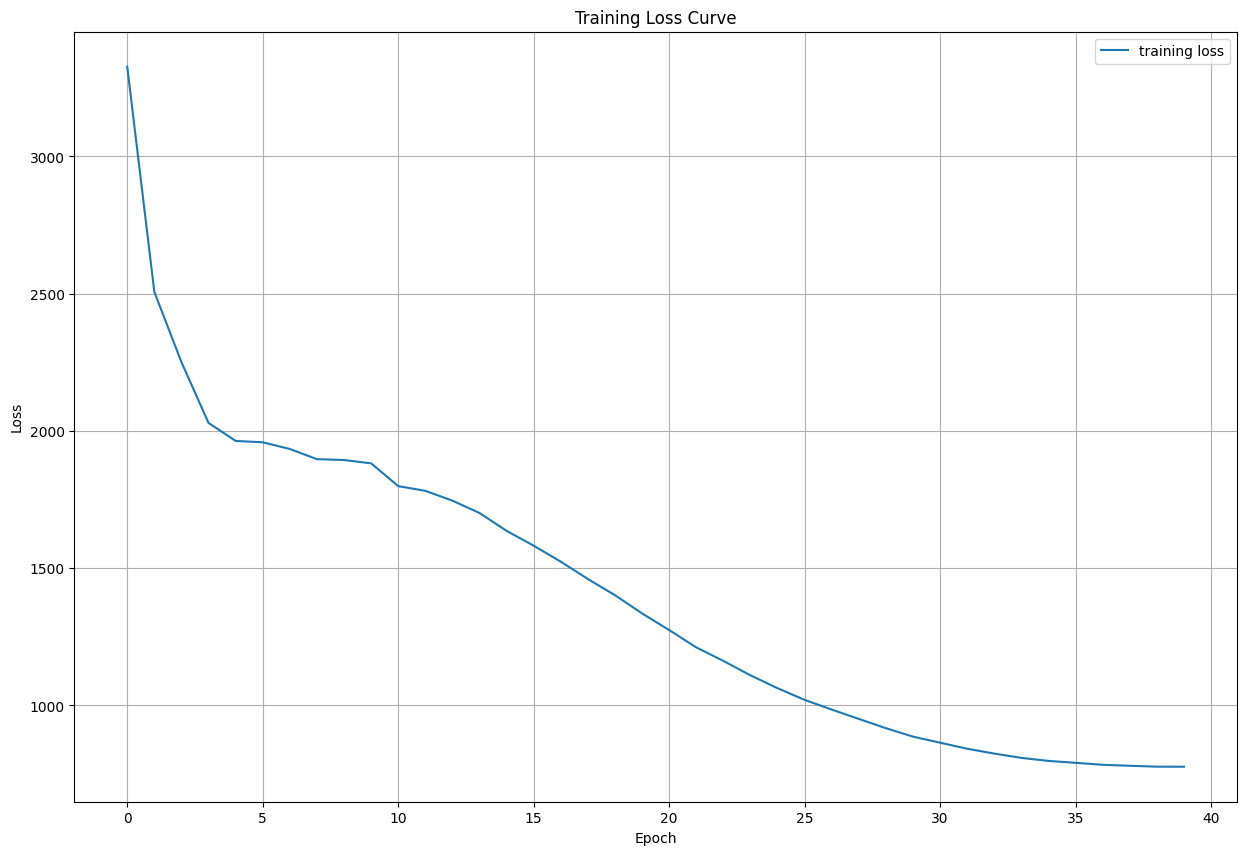

In [52]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(loss_curve)), np.array(loss_curve), label="training loss")
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.grid()
plt.show()

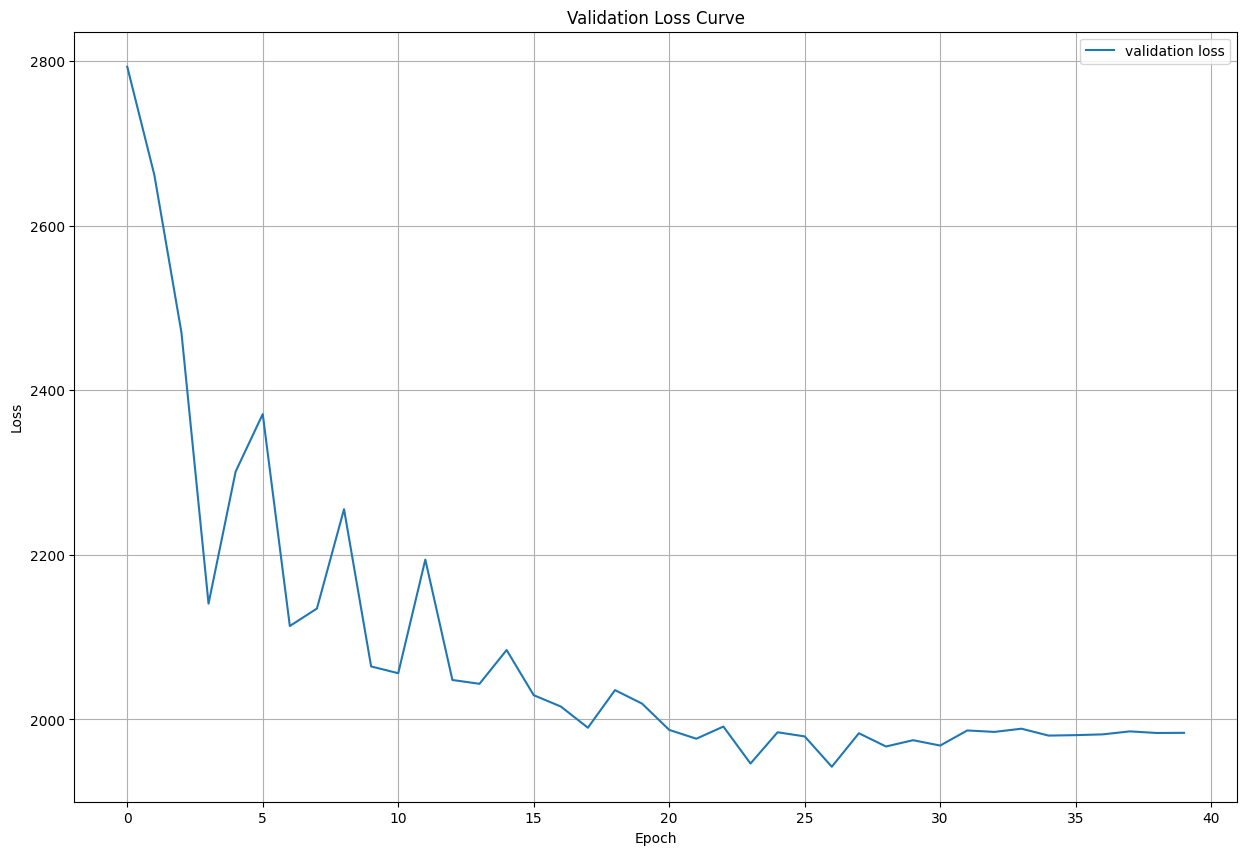

In [53]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(validation_curve)), validation_curve, label="validation loss")
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Curve')
plt.grid()
plt.show()

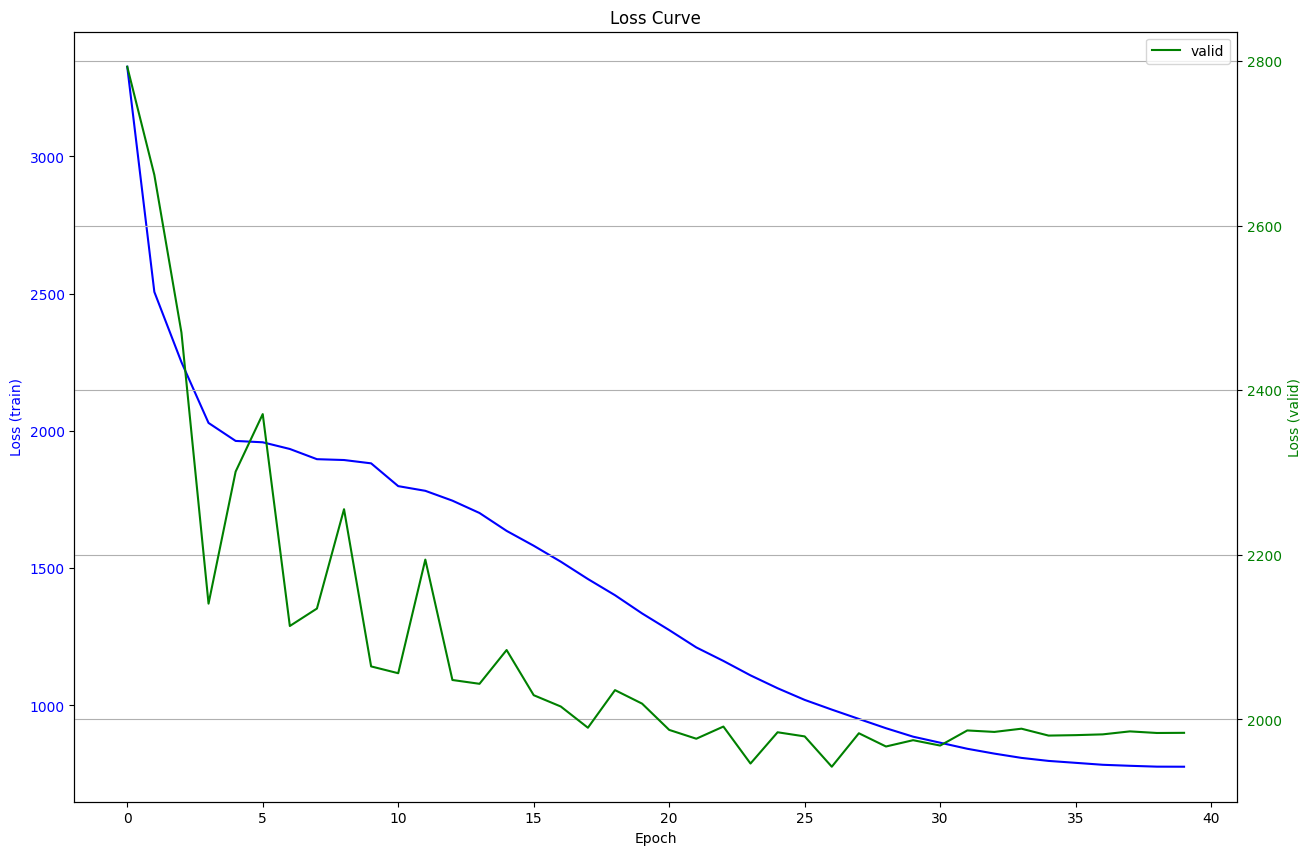

In [54]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.plot(np.arange(len(loss_curve)), np.array(loss_curve), 'b-', label='train')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (train)', color='b') 
ax1.tick_params(axis='y', labelcolor='b')  # Color of y-ticks

ax2 = ax1.twinx()

ax2.plot(np.arange(len(validation_curve)), validation_curve, 'g-', label='valid')
ax2.set_ylabel('Loss (valid)', color='g')  # Label for the second y-axis
ax2.tick_params(axis='y', labelcolor='g')  # Color of y-ticks

plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [55]:
print(loss_curve)
print(validation_curve)

[3326.934087890625, 2506.5400234375, 2250.6280234375, 2029.13705078125, 1963.58236328125, 1958.614109375, 1934.265302734375, 1897.073640625, 1894.01315625, 1881.921388671875, 1798.867009765625, 1781.816564453125, 1745.9792451171875, 1701.025634765625, 1635.867349609375, 1581.75236328125, 1523.63264453125, 1460.47828125, 1401.48605078125, 1335.057474609375, 1274.46695703125, 1211.303486328125, 1162.056947265625, 1109.4597065429687, 1062.5612109375, 1020.0790014648437, 984.723873046875, 950.6874453125, 916.8817099609375, 886.12633203125, 864.0770288085937, 842.0499790039063, 824.3624609375, 808.7789560546875, 797.7811171875, 790.7685815429687, 783.671576171875, 779.9895415039063, 776.8638862304688, 776.615564453125]
[2793.213134765625, 2661.71875, 2470.176513671875, 2140.738525390625, 2301.19287109375, 2371.0712890625, 2113.564453125, 2134.77197265625, 2255.498779296875, 2064.456787109375, 2056.181640625, 2194.262451171875, 2047.9490966796875, 2043.3231201171875, 2084.35302734375, 2029.4

# Predict

In [19]:
def predict_processed(model, data, num_limit=10):

    model.eval()

    test_dataset = ProcessedSparcSpectrogramDataset("test", data)

    data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, collate_fn=test_dataset.collate
    )
    
    with tqdm.notebook.tqdm(
        data_loader,
        total=len(data_loader)) as batch_iterator:
        model.eval()

        for i, batch in enumerate(batch_iterator, start=1):
            if i > num_limit: break
            _, seq_length, n_mels = batch["ai_sparc"].shape
            assert n_mels == 14 # sparc has 
            pred = model.transform(batch)
            assert pred.shape == (1, seq_length, n_mels)
            assert pred.squeeze().shape == (seq_length, n_mels)

            pred = pred.squeeze().detach().cpu().numpy()

            pred_ema = pred[:,:12]
            pred_pitch = pred[:, 12]*25 + 225
            pred_loudness = np.exp(pred[:, 13] - 2)

            wav_pred = coder.decode(
                ema=pred_ema, 
                pitch=pred_pitch, 
                loudness=pred_loudness, 
                spk_emb=test_dataset[i - 1]["data_sparc_spk_emb"].numpy()
            )

            wav_human = coder.decode(
                ema=test_dataset[i - 1]["data_sparc"].numpy(), 
                pitch=test_dataset[i - 1]["data_sparc_pitch"].numpy(), 
                loudness=test_dataset[i - 1]["data_sparc_loudness"].numpy(), 
                spk_emb=test_dataset[i - 1]["data_sparc_spk_emb"].numpy()
            )

            print(test_dataset[i - 1]["data_sparc_spk_emb"])

            wav_ai = coder.decode(
                ema=test_dataset[i - 1]["ai_sparc"].numpy(), 
                pitch=test_dataset[i - 1]["ai_sparc_pitch"].numpy(), 
                loudness=test_dataset[i - 1]["ai_sparc_loudness"].numpy(), 
                spk_emb=test_dataset[i - 1]["ai_sparc_spk_emb"].numpy()
            )

            torchaudio.save(f"test{i}_pred.wav", torch.tensor(wav_pred).unsqueeze(0), coder.sr)
            torchaudio.save(f"test{i}_actual.wav", torch.tensor(wav_human).unsqueeze(0), coder.sr)
            torchaudio.save(f"test{i}_ai.wav", torch.tensor(wav_ai).unsqueeze(0), coder.sr)

In [26]:
def predict_eval(model, data):

    model.eval()

    test_dataset = ProcessedSparcSpectrogramDataset("test", data)

    data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, collate_fn=test_dataset.collate
    )

    label_decoder = {
        0: 'confused',
        1: 'default',
        2: 'emphasis',
        3: 'enunciated',
        4: 'essentials',
        5: 'happy',
        6: 'laughing',
        7: 'longform',
        8: 'sad',
        9: 'singing',
        10:'whisper'
    }

    counter_map = dict()
    
    with tqdm.notebook.tqdm(
        data_loader,
        total=len(data_loader)) as batch_iterator:
        model.eval()

        for i, batch in enumerate(batch_iterator, start=1):

            c = batch["labels"].item()
            if c not in counter_map:
                counter_map[c] = 1
            elif counter_map[c] < 3:
                counter_map[c] += 1
            else:
                continue

            _, seq_length, n_mels = batch["ai_sparc"].shape
            assert n_mels == 14 # sparc has 
            pred = model.transform(batch)
            assert pred.shape == (1, seq_length, n_mels)
            assert pred.squeeze().shape == (seq_length, n_mels)

            pred = pred.squeeze().detach().cpu().numpy()

            pred_ema = pred[:,:12]
            pred_pitch = pred[:, 12]*25 + 225
            pred_loudness = np.exp(pred[:, 13] - 2)

            wav_pred = coder.decode(
                ema=pred_ema, 
                pitch=pred_pitch, 
                loudness=pred_loudness, 
                spk_emb=test_dataset[i - 1]["data_sparc_spk_emb"].numpy()
            )

            wav_human = coder.decode(
                ema=test_dataset[i - 1]["data_sparc"].numpy(), 
                pitch=test_dataset[i - 1]["data_sparc_pitch"].numpy(), 
                loudness=test_dataset[i - 1]["data_sparc_loudness"].numpy(), 
                spk_emb=test_dataset[i - 1]["data_sparc_spk_emb"].numpy()
            )

            wav_ai = coder.decode(
                ema=test_dataset[i - 1]["ai_sparc"].numpy(), 
                pitch=test_dataset[i - 1]["ai_sparc_pitch"].numpy(), 
                loudness=test_dataset[i - 1]["ai_sparc_loudness"].numpy(), 
                spk_emb=test_dataset[i - 1]["ai_sparc_spk_emb"].numpy()
            )

            torchaudio.save(f"{label_decoder[c]}_test{i}_pred.wav", torch.tensor(wav_pred).unsqueeze(0), coder.sr)
            torchaudio.save(f"{label_decoder[c]}_test{i}_actual.wav", torch.tensor(wav_human).unsqueeze(0), coder.sr)
            torchaudio.save(f"{label_decoder[c]}_test{i}_ai.wav", torch.tensor(wav_ai).unsqueeze(0), coder.sr)

In [27]:
predict_eval(transformer_encoder_model, dataset)

  0%|          | 0/453 [00:00<?, ?it/s]

In [20]:
predict_processed(transformer_encoder_model, dataset)

  0%|          | 0/453 [00:00<?, ?it/s]

tensor([-7.6677e-01, -4.4010e-01, -3.5134e-01, -1.0840e-01,  1.1644e+00,
         4.1495e-01,  4.6036e-01,  2.2821e-01, -4.9158e-01, -5.9831e-02,
         1.0870e-01,  5.8943e-01, -1.7288e-01, -7.0199e-01, -6.1033e-01,
        -8.0787e-01, -5.0821e-01, -7.4104e-02, -5.6723e-01, -5.2066e-01,
         2.6124e-01,  4.6457e-01,  1.3760e-02,  1.4124e-01,  1.5991e-01,
         7.7423e-02,  2.6986e-01,  8.5615e-01, -4.1716e-01, -2.3076e-01,
        -9.7690e-02, -6.2255e-02,  8.9143e-02, -9.0938e-01, -6.8639e-01,
        -9.5916e-04, -8.4135e-01,  3.2860e-01,  7.3121e-01,  7.7298e-01,
         6.8518e-01, -5.0460e-01, -4.1289e-01,  2.2330e-01,  1.4559e-01,
         5.3811e-01,  3.7308e-01,  8.0833e-01, -4.6843e-01, -4.9028e-01,
         3.6630e-01,  4.1606e-01,  7.7105e-01, -4.9490e-01, -4.9601e-01,
        -4.1234e-01,  2.4565e-01,  2.4027e-01,  5.0166e-02, -1.5994e-01,
         8.2064e-02, -1.4679e-01, -6.1186e-01, -8.1365e-01])
tensor([-1.0224, -0.5720, -0.7544, -0.1566,  0.8214,  0.9248,  

In [14]:
test_dataset = ProcessedSparcSpectrogramDataset("test", dataset)

In [19]:
test_dataset[0]["label"].item()

3

In [30]:
def display(idx, typ):
    assert typ in ("pred", "ai", "actual")
    label_decoder = {
        0: 'confused',
        1: 'default',
        2: 'emphasis',
        3: 'enunciated',
        4: 'essentials',
        5: 'happy',
        6: 'laughing',
        7: 'longform',
        8: 'sad',
        9: 'singing',
        10:'whisper'
    }
    title_map = {
        "pred": "Prediction",
        "ai": "Input",
        "actual": "Actual"
    }
    print(label_decoder[test_dataset[idx - 1]["label"].item()])
    waveform, sample_rate = torchaudio.load(f"/kaggle/working/test{idx}_{typ}.wav")
    ipd.display(ipd.Audio(waveform, rate=sample_rate))
    view_spectrogram(get_spectrogram_from_waveform(waveform, sample_rate), title=f"Test {idx} {title_map[typ]}")

### Example 7

sad


(80, 378)


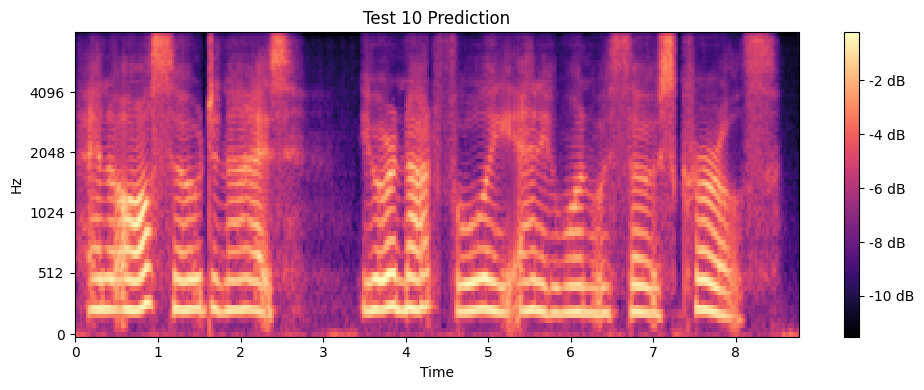

In [31]:
display(10, "pred")

sad


(80, 378)


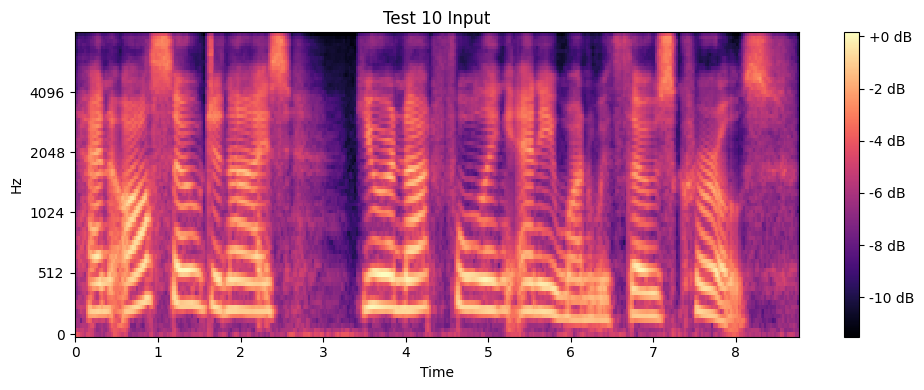

In [32]:
display(10, "ai")

sad


(80, 378)


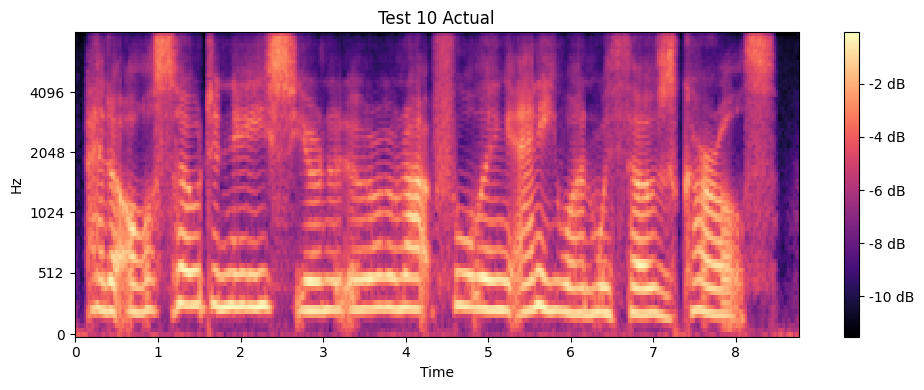

In [33]:
display(10, "actual")

### Example 2

happy


(80, 283)


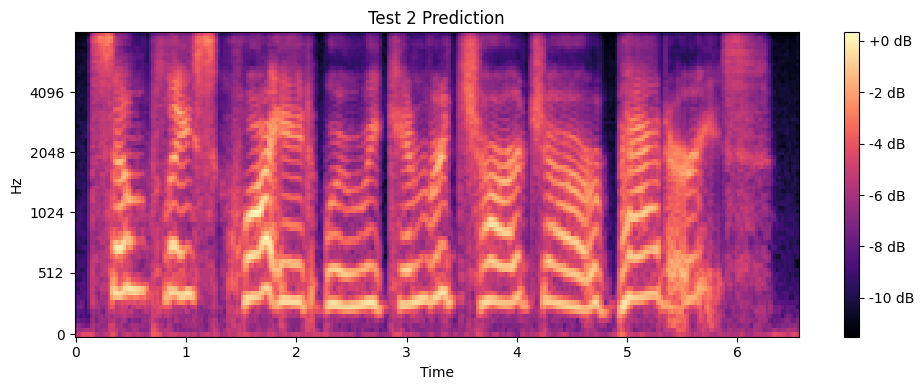

In [34]:
display(2, "pred")

happy


(80, 283)


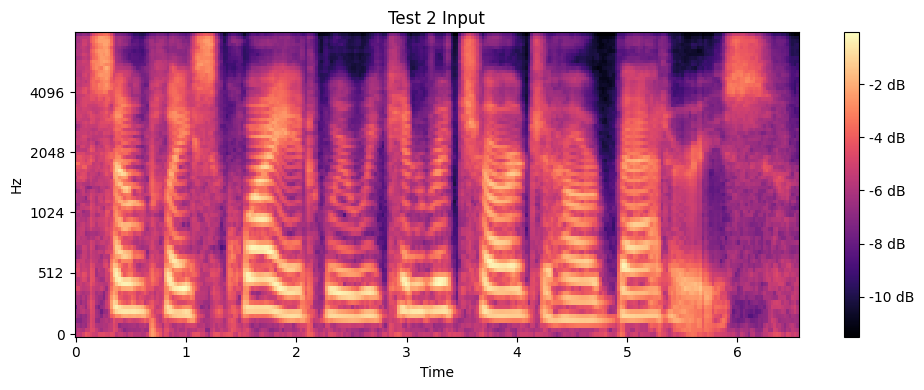

In [35]:
display(2, "ai")

happy


(80, 283)


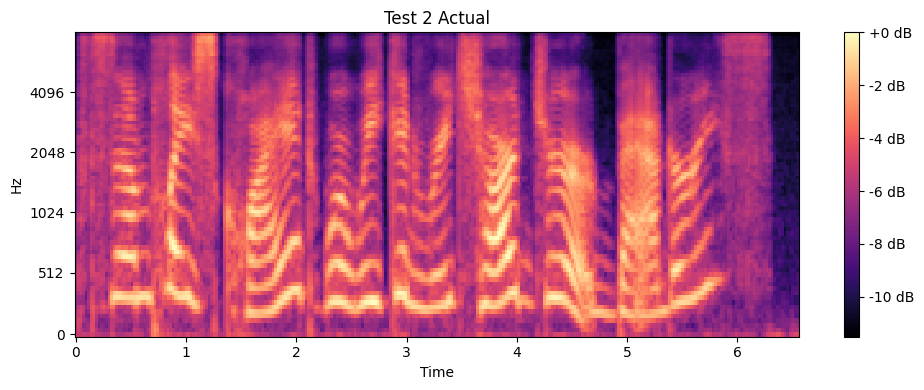

In [36]:
display(2, "actual")

### Example 8

whisper


(80, 187)


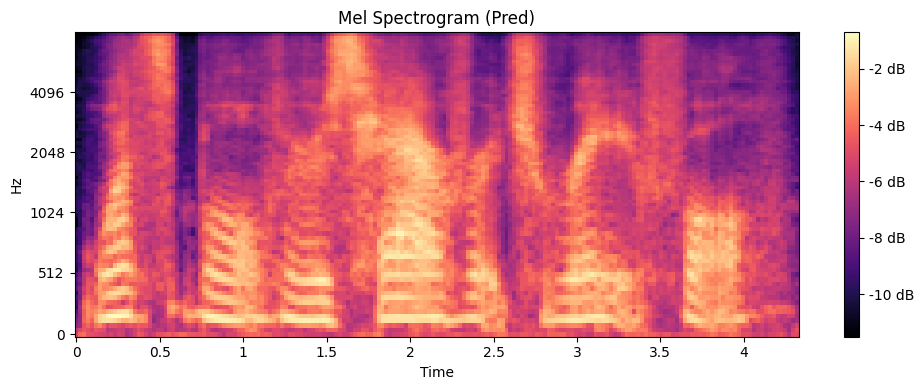

In [65]:
display(8, "pred")

whisper


(80, 187)


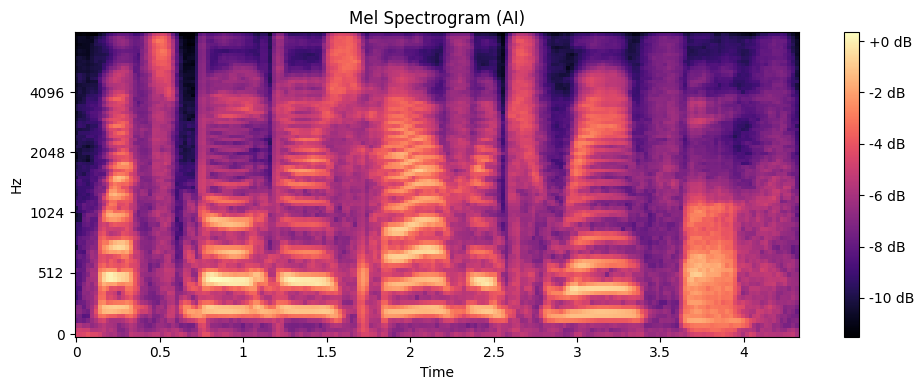

In [66]:
display(8, "ai")

whisper


(80, 187)


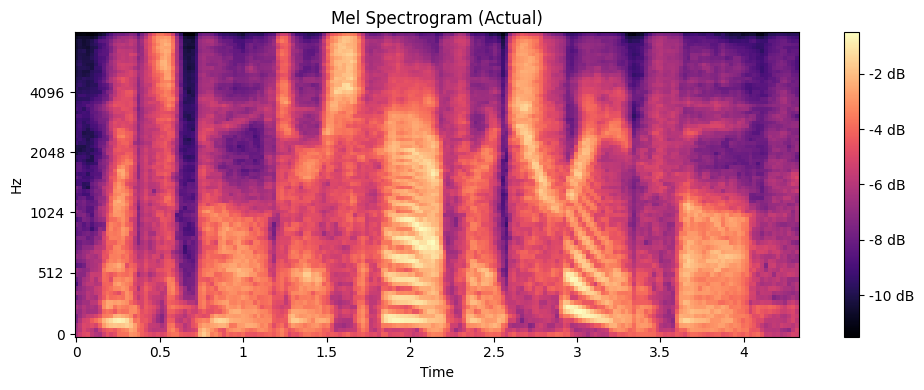

In [67]:
display(8, "actual")

### Example 9

laughing


(80, 221)


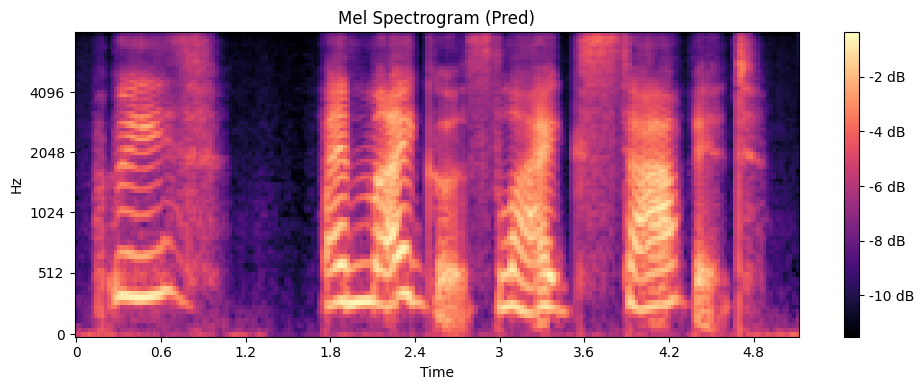

In [68]:
display(9, "pred")

laughing


(80, 221)


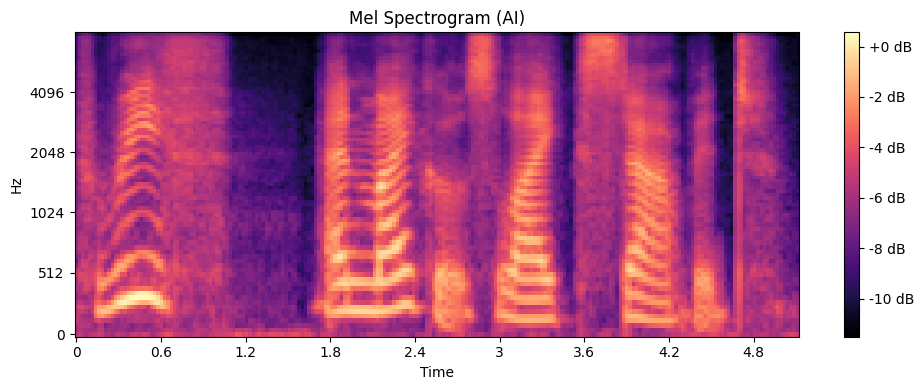

In [69]:
display(9, "ai")

laughing


(80, 221)


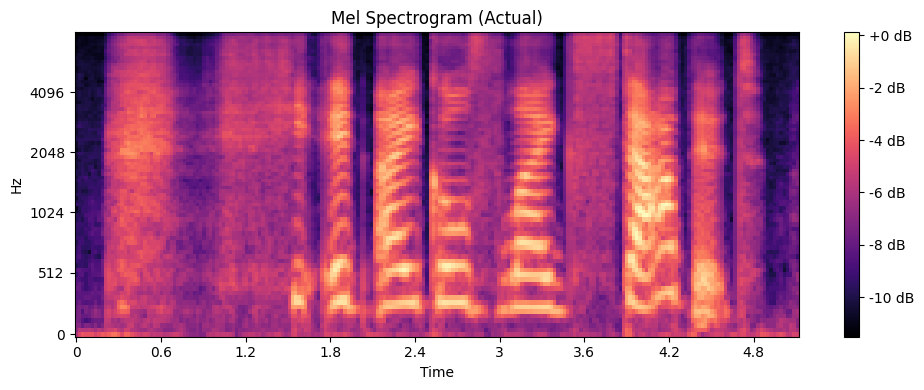

In [70]:
display(9, "actual")